### Generating the dataset

In [1]:
using PyPlot

In [2]:
srand(1)

# number of users
d1 = 90;

# number of items
d2 = 110;

# number of observations
n = 25000;

In [3]:
# generate the hidden ratings
ThetaS = rand(d1,4) * rand(4,d2)

# Need to have the sum of rows equaling 0
for i = 1:d1
    ThetaS[i,:] -= mean(ThetaS[i,:])
end

# Need to make the Frobenius norm <= 1
ThetaS = ThetaS / vecnorm(ThetaS);

In [4]:
y = []
X = []
P = []

for i = 1:n
    Xi = zeros(d1, d2)
    
    lin = rand(1:d1)
    c1 = rand(1:d2)
    c2 = rand(1:d2)
    while c2 == c1
        c2 = rand(1:d2)
    end
    
    Xi[lin,c1] = 1
    Xi[lin,c2] = -1
    Xi = Xi * sqrt(d1 * d2)
    
    push!(X, Xi)
    push!(P, [lin, c1, c2])
    
    if ThetaS[lin,c1] > ThetaS[lin,c2]
        push!(y, 1)
    else
        push!(y, 0)
    end
end

### Helper functions

In [5]:
function nucNorm(A)
    return sum(svd(A)[2])
end

nucNorm (generic function with 1 method)

In [6]:
# make sure the matrix's rows are centered

function adjust(X)
    ans = copy(X)
    
    for i = 1:size(X)[1]
        ans[i,:] -= mean(ans[i,:])
    end
    
    return ans
end

adjust (generic function with 1 method)

In [7]:
# The objective function

function obj(Theta, ns)
    ans = 0
    
    for i = 1:ns
        t = sqrt(d1 * d2) * (ThetaS[P[i][1], P[i][2]] - ThetaS[P[i][1], P[i][3]])
#         t = trace(Theta' * X[i])
        ans = ans + log(1 + e^t) - y[i] * t
    end
    
    return ans / ns
end

obj (generic function with 1 method)

In [8]:
# Compute the derivative of the objective loss
# Theta is our current guess
# numSamples represents the number of X's we are considering

function deltaF(Theta, ns)
    
    ans = zeros(d1,d2)
    
    for i = 1:ns
        tr = sqrt(d1 * d2) * (ThetaS[P[i][1], P[i][2]] - ThetaS[P[i][1], P[i][3]])
        ans = ans + (e^tr / (1 + e^tr) - y[i]) * X[i]
    end
    
    return ans / ns
    
end

deltaF (generic function with 1 method)

In [9]:
# The proximal function
# return the matrix X that minimizes lambda * ||X||_nuc + 1/(2 lambda_k) || X - V ||_F^2
# equivalent to (lamda*lambda_k) ||X||_nuc + 1/2 || X - V ||_F^2

function prox(lambda, V)
    
    A,S,B = svd(V)
    S = max(S - lambda, 0)
    
    return adjust(A * diagm(S) * B')
    
end

prox (generic function with 1 method)

In [10]:
function checkKKT(lamb, Theta, ns)
    println("Checking KKT conditions")
    
    tot = 0
    
    for i = 1:ns
        tr = sqrt(d1 * d2) * (ThetaS[P[i][1], P[i][2]] - ThetaS[P[i][1], P[i][3]])
        tot = tot + (e ^ tr / (1 + e ^ tr) - y[i]) * X[i]
    end
    
    tot = tot / ns
    
    U,S,V = svd(Theta)
    k = rank(Theta)
    U = U[:,1:k]
    V = V[:,1:k]
    
    tot = tot + lamb * U * V'
    
    println("norm = ", norm(tot), "    lambda = ", lamb)
#     if norm(tot) <= lambda
#         println("GOOD - the norm is smaller than lambda")
#     else
#         println("OOPS - the norm is greater than lambda")
#     end
    
    println(norm(U' * tot))
    
    println(norm(tot * V))
    
end

checkKKT (generic function with 1 method)

##### As a sanity check, make sure that our gradient steps indeed decreases obj loss

In [11]:
Theta = adjust(rand(d1,d2))

println("Hidden loss ", obj(ThetaS, n))
println("Current loss ", obj(Theta, n))

@time for stp = 1:5
    alpha = 1.0

    newTheta = Theta - alpha * deltaF(Theta, n)
    newTheta = adjust(newTheta)

    println("Loss after ", stp, " steps: ", obj(newTheta, n))
    
    Theta = copy(newTheta)
end

Hidden loss 0.3446926995463647
Current loss 0.3446926995463647
Loss after 1 steps: 0.3446926995463647
Loss after 2 steps: 0.3446926995463647
Loss after 3 steps: 0.3446926995463647
Loss after 4 steps: 0.3446926995463647
Loss after 5 steps: 0.3446926995463647
  5.496975 seconds (4.90 M allocations: 18.539 GB, 18.46% gc time)


#### We'll pick a specific number of samples in terms of n

In [12]:
numSamples = []
for den = [3,2,1.5,1]
    push!(numSamples, convert(Int64, floor(n / den)))
end

#### Let's test out the algorithm

In [13]:
overallLF = []

@time for ns = numSamples
    LF = []
    
    println("working with ", ns, " samples")
    
    curTheta = zeros(d1,d2)
    lambda = 0.1   # the regularization parameter
    lambda_k = .05   # the step size
    
    maxit = 200
    @time for steps = 1:maxit
        lambda_k = lambda_k - 0.04 / maxit
        
        # first, go in the direction of f
        V = curTheta - lambda_k * deltaF(curTheta, ns)
        
        # now, perform the proximal step
        newTheta = prox(lambda * lambda_k, V)

        # some information about runs
        if steps % 25 == 0 || steps == maxit
            println("at iteration ", steps)
            
            if steps == maxit
                println("f + g = ", obj(curTheta, ns) + lambda * nucNorm(curTheta))
                println("f = ", obj(curTheta, ns))
                println("g = ", lambda * nucNorm(curTheta))
                println("Loss = ", vecnorm(ThetaS - newTheta)^2)
                println()
                checkKKT(lambda, newTheta, ns)
                println()
            end
        end

        # update the loss array
        push!(LF, vecnorm(ThetaS - newTheta)^2)
        
        # if I hit the max number of steps, stop anyway
        if steps == maxit
            push!(overallLF, vecnorm(ThetaS - newTheta)^2)
        end
        
        # update Theta for the next iteration
        curTheta = copy(newTheta)
    end
    
#     dims = convert(Int64, (d1+d2)/2)
#     filename = string("./data/", dims, "-", ns, ".txt")
#     writedlm(filename, LF)
    
    println()
    println()
end

working with 8333 samples
at iteration 25
at iteration 50
at iteration 75
at iteration 100
at iteration 125
at iteration 150
at iteration 175
at iteration 200
f + g = 0.4252268636349686
f = 0.34645175214075097
g = 0.0787751114942176
Loss = 0.46351664075410975

Checking KKT conditions
norm = 0.11617533852546018    lambda = 0.1
0.11617533852546022
0.11617533852546022

 86.616763 seconds (36.87 M allocations: 248.224 GB, 16.11% gc time)


working with 12500 samples
at iteration 25
at iteration 50
at iteration 75
at iteration 100
at iteration 125
at iteration 150
at iteration 175
at iteration 200
f + g = 0.41213274906443564
f = 0.34622669736938994
g = 0.06590605169504571
Loss = 0.444593675495926

Checking KKT conditions
norm = 0.1103953964741122    lambda = 0.1
0.11039539647411224
0.11039539647411224

131.695427 seconds (55.18 M allocations: 372.186 GB, 20.44% gc time)


working with 16666 samples
at iteration 25
at iteration 50
at iteration 75
at iteration 100
at iteration 125
at iteratio

In [14]:
# writedlm(string("./data/", convert(Int64, (d1+d2)/2), "-final.txt"), overallLF)

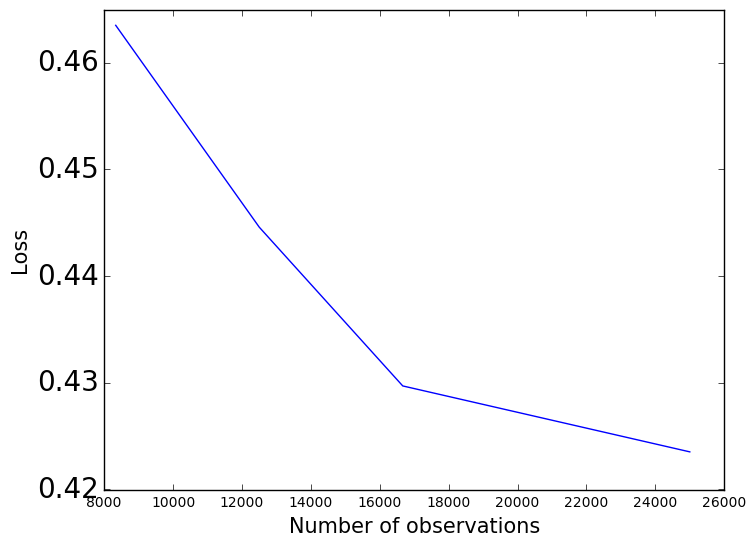

In [25]:
# plotting the loss function
plot(numSamples, overallLF)
xlabel("Number of observations", size=15)
ylabel("Loss", size=15)
axes()[:tick_params]("y",labelsize=20)
axes()[:tick_params]("x",labelsize=10)

In [16]:
# newLF = []
# for i = 1:length(LF)
#     push!(newLF, log(LF[i]))
# end

# plot(newLF)

In [17]:
# writedlm("./data/t.txt", LF)

In [18]:
overallLF

4-element Array{Any,1}:
 0.463517
 0.444594
 0.42971 
 0.423528